In [1]:
import numpy as np
from qutip import *
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib
from math import factorial
from matplotlib import pyplot as plt
from itertools import product,combinations
from scipy.optimize import curve_fit
plt.rc('font', size=50)          # controls default text sizes
# plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
# plt.rc('legend', fontsize=20)    # legend fontsize
# plt.rc('lines', markersize = 10)

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 16,12
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['lines.linewidth'] = 4
props = dict(boxstyle='round', alpha=0.01)

/home/abhirup/.local/lib/python3.9/site-packages/qutip/configrc.py:326: UserWarning: Invalid qutip config variable in qutiprc: num_cpus
  warnings.warn("Invalid qutip config variable in qutiprc: "


In [2]:
def get_ham(f1, f2, t, N, K=2):
    H = 0
    for i in range(N):
        ops = [identity(2)]*(2*N)*K
        for sigma in [0,1]:
            ops = [identity(2)]*(2*N)*K
            ops[2*i+sigma] = create(2)
            ops[(2*(i+1)+sigma)%(2*N)] = destroy(2)
            H += -t*tensor(ops)
            if K == 2:
                ops = [identity(2)]*(2*N)*K
                ops[2*i+sigma + 2*N] = create(2)
                ops[(2*(i+1)+sigma)%(2*N) + 2*N] = destroy(2)
                H += -t*tensor(ops)
    
    if f1 != 0 and K == 1:
        num = create(2)*destroy(2)
        H += -(f1/2) * tensor([identity(2)]*2 + [num, identity(2)] + [identity(2)]*2*(N-2))
        H += -(f1/2) * tensor([identity(2)]*2 + [identity(2), num] + [identity(2)]*2*(N-2))
        H += f1 * tensor([identity(2)]*2 + [num, num] + [identity(2)]*2*(N-2))
    
    if f2 != 0 and K > 1:
        NFL_part = 0
        Sz = 0.5*(tensor(create(2)*destroy(2), identity(2)) - tensor(identity(2), create(2)*destroy(2)))
        splus = tensor(create(2), destroy(2))
        sminus = tensor(destroy(2), create(2))

        if N > 2:
            rest = tensor([identity(2)]*(2*(N-2)))
            NFL_part += tensor(Sz**2, sminus, rest, splus, tensor([identity(2)]*2), rest)
            NFL_part += tensor(Sz**2, tensor([identity(2)]*2), rest, sminus, splus, rest)
            NFL_part += tensor(splus, sminus, rest, Sz**2, tensor([identity(2)]*2), rest)
            NFL_part += tensor(splus, tensor([identity(2)]*2), rest, Sz**2, sminus, rest)
        else:
            NFL_part += tensor(Sz**2, sminus, splus, tensor([identity(2)]*2))
            NFL_part += tensor(Sz**2, tensor([identity(2)]*2), sminus, splus)
            NFL_part += tensor(splus, sminus, Sz**2, tensor([identity(2)]*2))
            NFL_part += tensor(splus, tensor([identity(2)]*2), Sz**2, sminus)

        H += f2 * (NFL_part + NFL_part.dag())
    return H

In [ ]:
# t = 0.5
# J = 1
# f2 = 8*t**2/J
# print ("NFL")
# for N in range(2, 4):
#     print ("N=",N)
#     H = get_ham(0, f2, t, N, K=2)
#     E, X = H.eigenstates()
#     Xgs = X[E == min(E)]
#     H0 = get_ham(0, 0, t, N, K=2)
#     E0, X0 = H0.eigenstates()
#     Xgs0 = X0[E0 == min(E0)]
#     for X, X0 in product(Xgs, Xgs0):
#         print (np.abs((X.dag()*X0)[0])**2)

t = 0.01
J = 1
print ("FL")
f1 = 32*t**4 / (3 * J**3)
for N in range(2, 8):
    print ("N=",N)
    H = get_ham(f1, 0, t, N, K=1)
    E, X = H.eigenstates()
    Xgs = X[E == min(E)]
    H0 = get_ham(0, 0, t, N, K=1)
    E0, X0 = H0.eigenstates()
    Xgs0 = X0[E0 == min(E0)]
    for X, X0 in product(Xgs, Xgs0):
        print (np.abs((X.dag()*X0)[0])**2)

FL
N= 2
[[1.]]
N= 3
[[0.99894482]]
N= 4
[[1.]]
N= 5
[[2.34705879e-07]]
[[0.10501215]]
[[0.87707023]]
[[0.00055238]]
[[0.56689345]]
[[0.11621561]]
[[0.00047527]]
[[0.32719294]]
[[0.00660923]]
[[0.99897211]]
[[0.00090147]]
[[0.00010493]]
N= 6
[[1.]]
N= 7


In [2]:
def get_basis(n, K=2):
    N = 2*K*n
    basis = []
    for i in range(N+1):
        selections = [list(item) for item in combinations(range(N), i)]
        # print (selections)
        for sel in selections:
            base = np.zeros(N)
            base[sel] = 1
            basis.append(base)
        
    return basis

basis = get_basis(2)


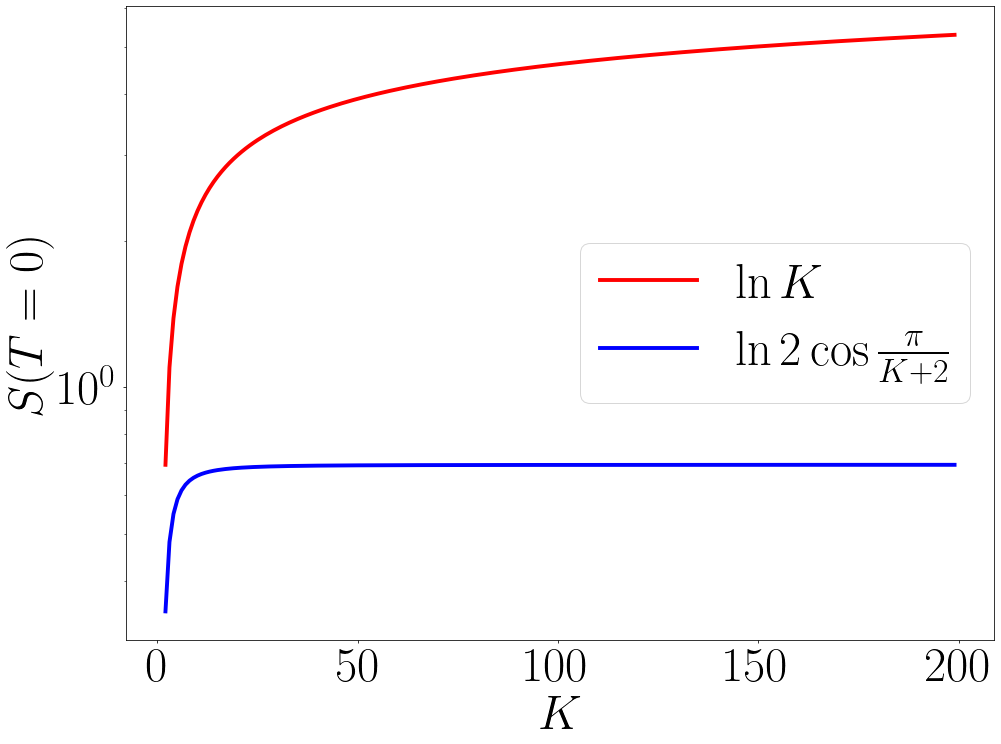

In [3]:
K = np.arange(2, 200, 1)
f1 = np.log(K)
f2 = np.log(2*np.cos(np.pi/(K+2)))
plt.plot(K, f1, label=r"$\ln K$", color='r')
plt.plot(K, f2, label=r"$\ln 2\cos \frac{\pi}{K+2}$", color='b')
plt.yscale("log")
plt.legend()
plt.xlabel(r"$K$")
plt.ylabel(r"$S(T=0)$")
plt.savefig("entropy_comparison.pdf", bbox_inches='tight')